In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "ranked_quadh_withbkg"

In [5]:
module.Run2_UL18

/store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9
   JetHT_Data
   QCD
   TTJets

In [6]:
signal = ObjIter([ Tree(f) for f in module.signal_list ])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])

100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


In [7]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

In [8]:
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'))

[None, None, None, None, None]

In [9]:
# path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker/20221026_ranger_lr0.0047_batch128_m10_withbkg"
# path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_opt/20221101_ranger_lr0.0047_batch256_m10_cosphi_withbkg/"
# path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models//quadh_ranker_opt/20221102_ranger_lr0.0047_batch256_m10_cosphi_weighted_mse_withbkg/"
# path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_opt/20221103_ranger_lr0.0047_batch256_m10_cosphi_weighted_mse_withbkg/"
path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_opt/20221108_ranger_lr0.0047_batch256_m10_cosphi_weighted_mse_withbkg/"
# path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker/20221029_ranger_lr0.0047_batch256_m10_cosphi_withbkg"


In [10]:
(signal+bkg).apply(lambda t : eightb.load_quadh(t, path), report=True)
# (signal).apply(lambda t : eightb.load_quadh(t, path), report=True)


100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


[None, None, None, None, None]

In [11]:
def nfound_higgs(t):
    nhiggs = ak.sum(t.higgs_signalId>-1,axis=-1)
    t.extend(nfound_paired_h_gnn=nhiggs)
signal.apply(nfound_higgs)

[None, None, None]

100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


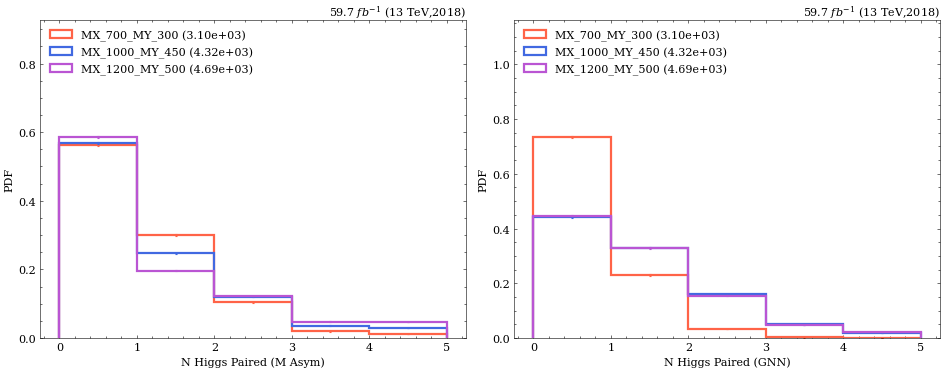

In [23]:
study.quick(
    signal,
    legend=True,
    efficiency=True,
    varlist=['nfound_paired_h','nfound_paired_h_gnn'],
    xlabels=['N Higgs Paired (M Asym)','N Higgs Paired (GNN)']
)

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


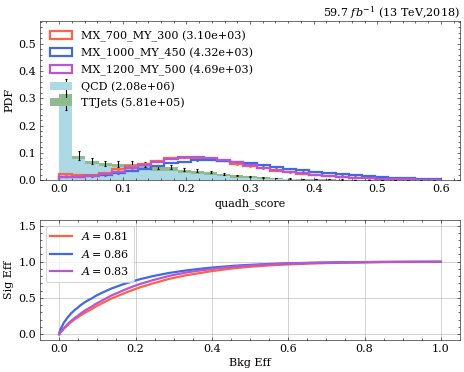

In [17]:
study.quick( 
    signal+bkg,
    legend=True,
    efficiency=True,
    varlist=['quadh_score'],
    binlist=[(0.,0.6,30)],

    **study.auroc,
)

In [19]:
varinfo.higgs_m = dict(bins=(0,300,30))

100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


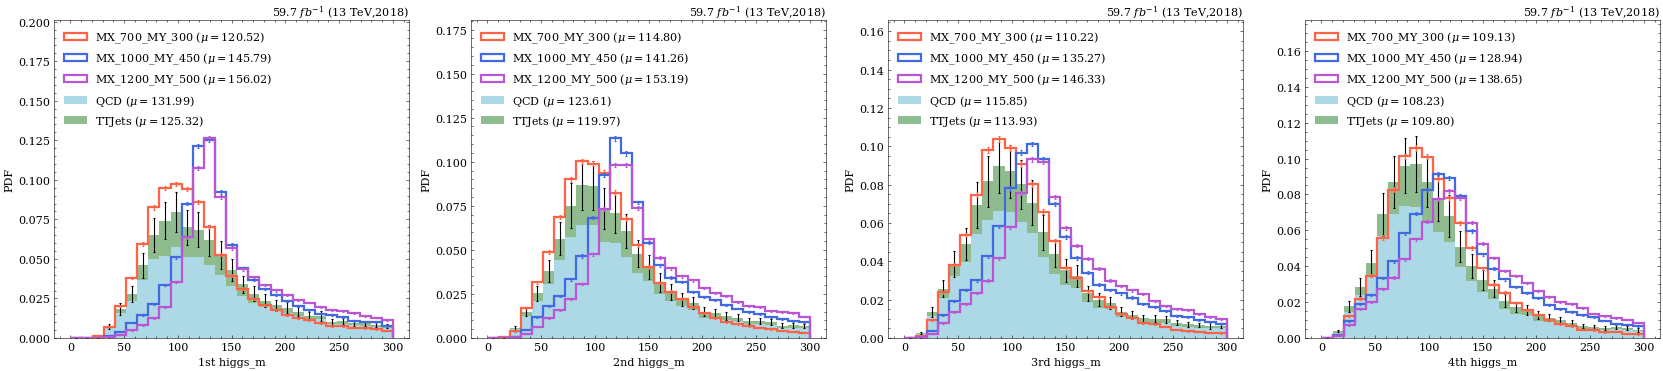

In [20]:
study.quick(
    signal+bkg,
    # signal,
    legend=True, h_label_stat='$\mu={stats.mean:0.2f}$',
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/higgs_m'
)

100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


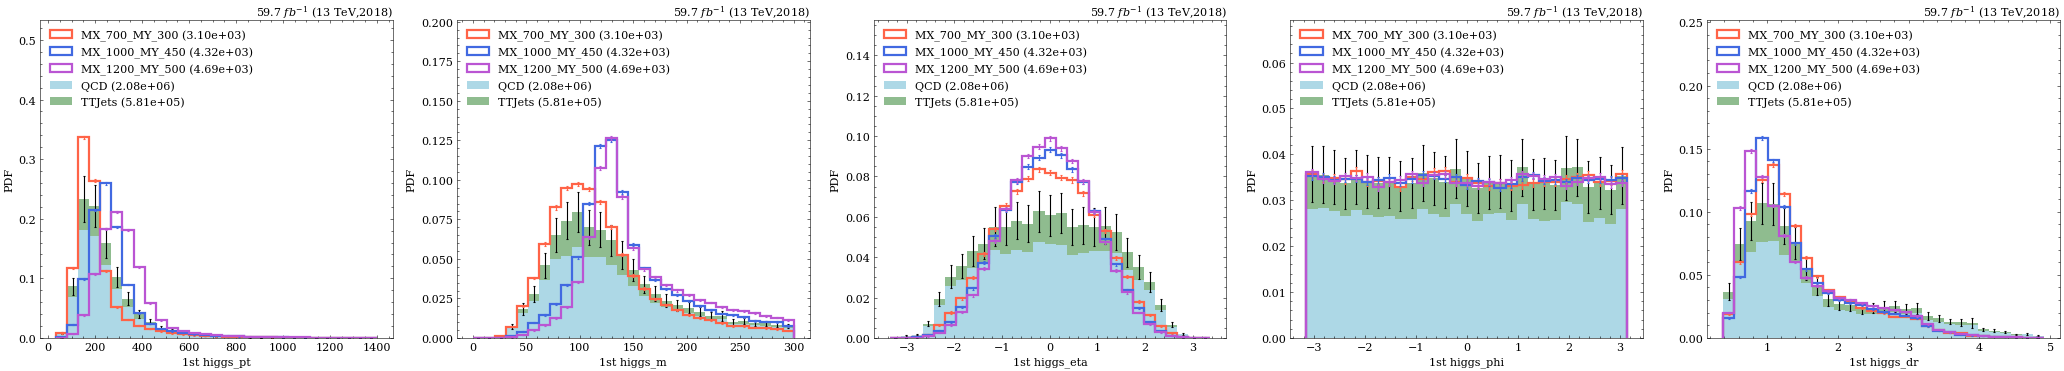

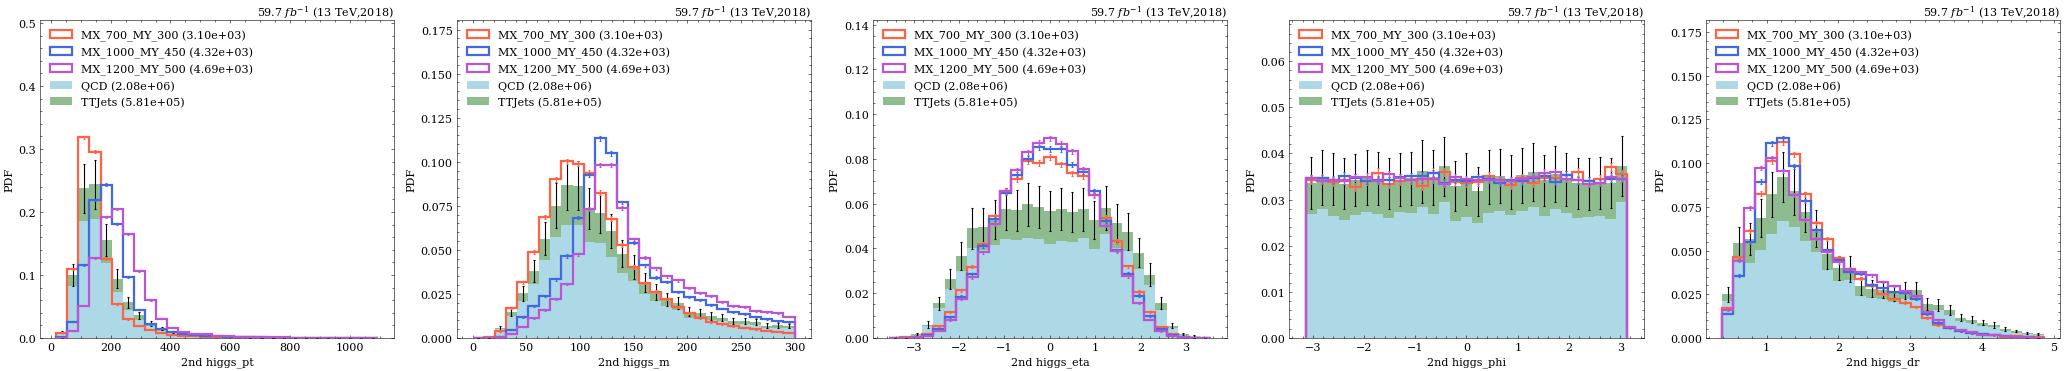

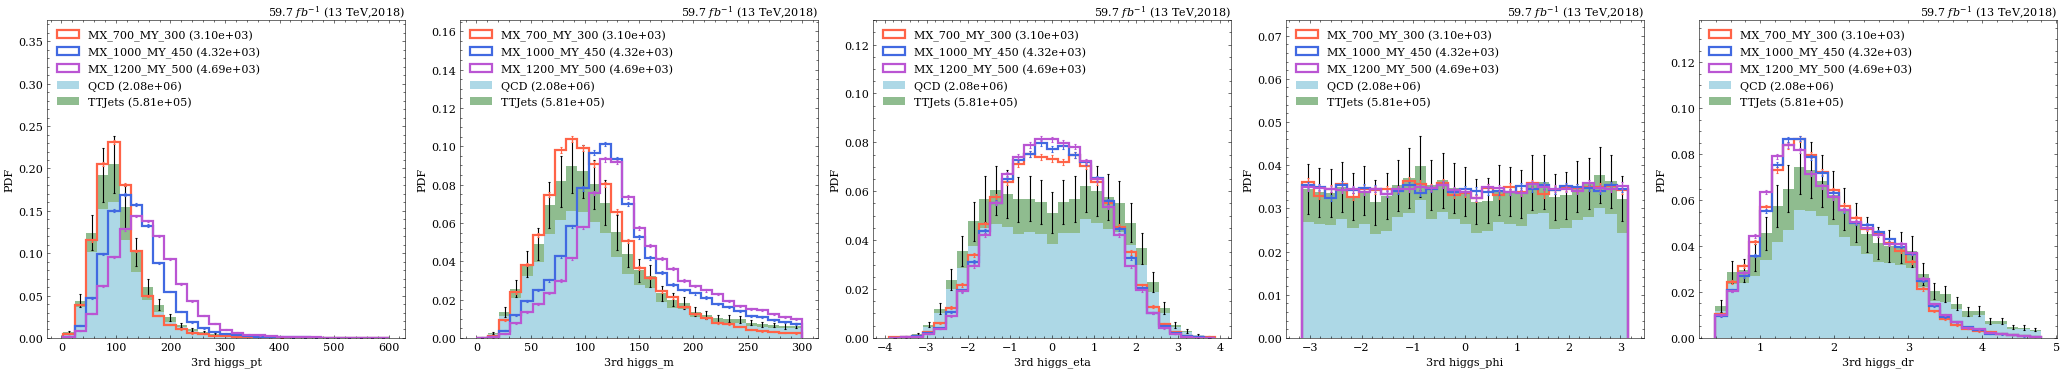

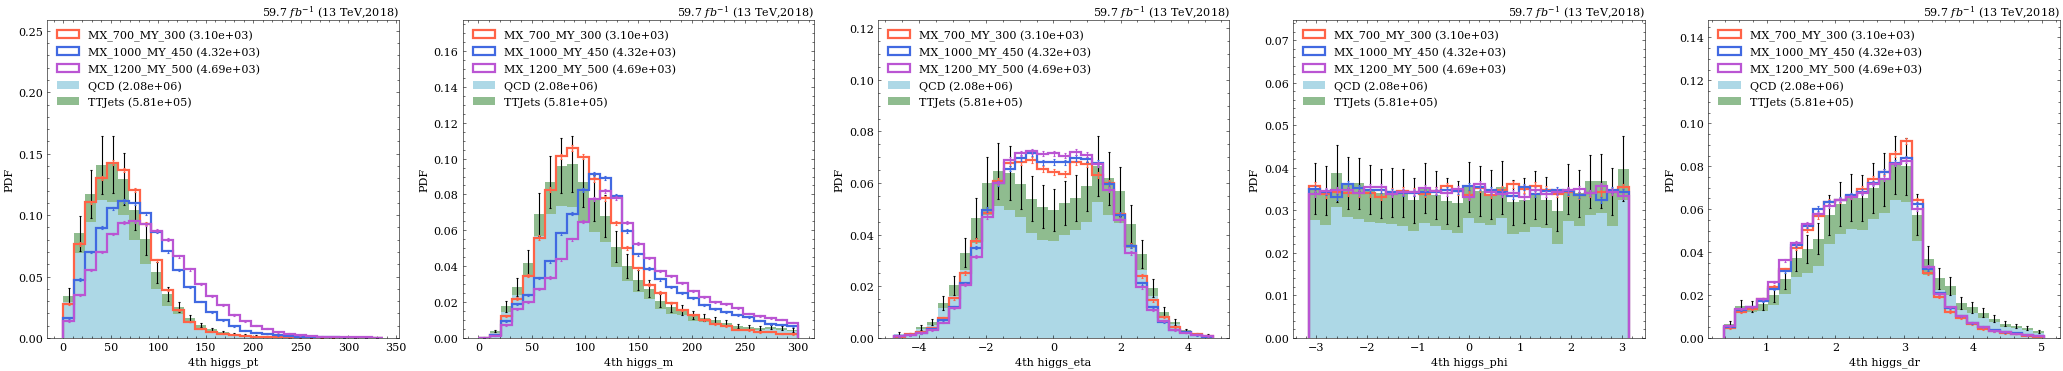

In [21]:
for i in range(4):
    study.quick( 
        signal+bkg, 
        # signal, 
        legend=True, efficiency=True,
        varlist=[f'higgs_{var}[:,{i}]' for var in ('pt','m','eta','phi','dr')],
        dim=-1,
        saveas=f'{ordinal(i)}_pt_higgs'
    )

100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


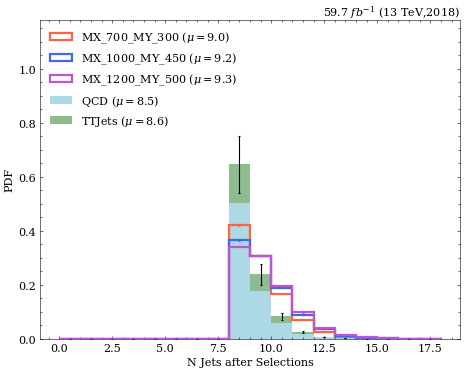

In [16]:
study.quick(
    signal+bkg, legend=True, h_label_stat='mean',
    efficiency=True,
    varlist=['n_jet'],
    xlabels=['N Jets after Selections'],
    saveas=f'{dout}/n_presel_jets'
)

100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


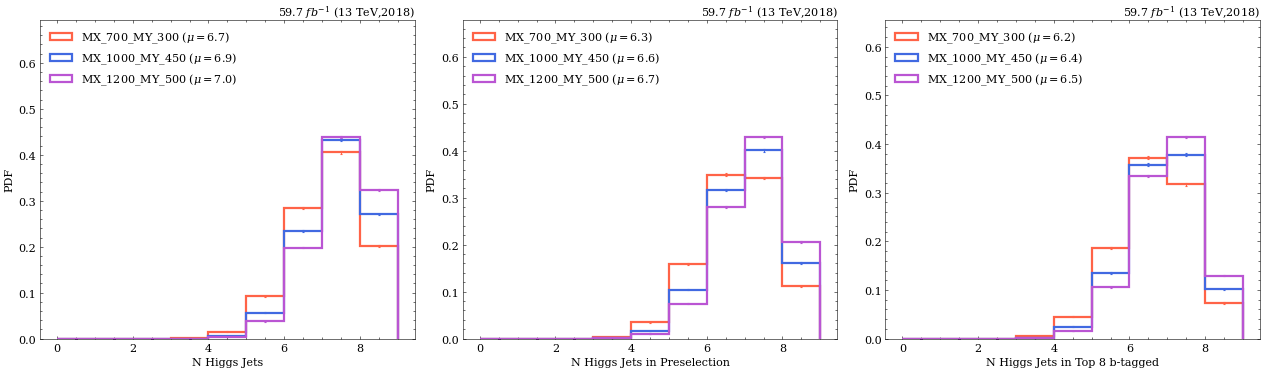

In [17]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    efficiency=True,
    varlist=['nfound_all','nfound_presel','nfound_select'],
    xlabels=['N Higgs Jets','N Higgs Jets in Preselection','N Higgs Jets in Top 8 b-tagged'],
    dim=-1,
    saveas=f'{dout}/n_higgs_jets'
)

In [18]:
njets_lost = lambda t:t.nfound_presel-t.nfound_select

def frac_events(t):
    nlost = njets_lost(t)
    return f"{ak.mean(nlost>0):0.2%}"

signal.apply(frac_events)

['14.56%', '17.56%', '19.26%']

100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


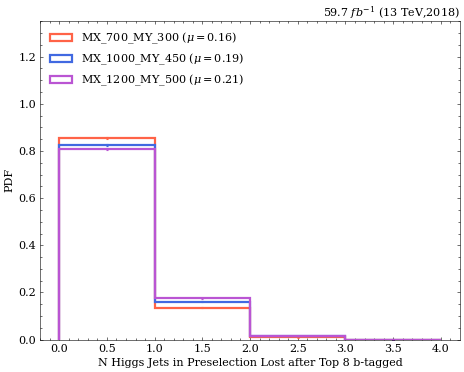

In [19]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    varlist=[njets_lost],
    xlabels=['N Higgs Jets in Preselection Lost after Top 8 b-tagged'],
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/n_higgs_jets_lost'
)

100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


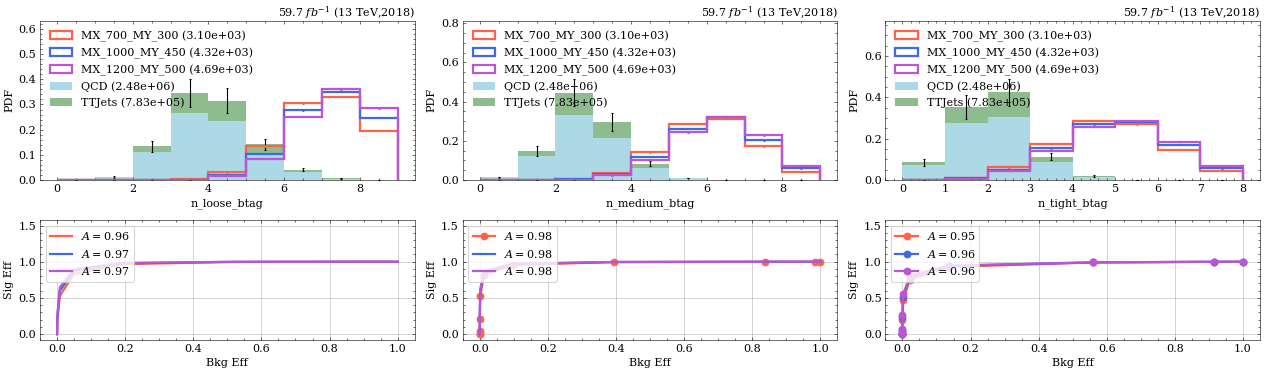

In [20]:
study.quick(
    bkg+signal, legend=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    efficiency=True, dim=-1,
    **study.auroc,

    saveas=f'{dout}/btag_multi'
)

100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


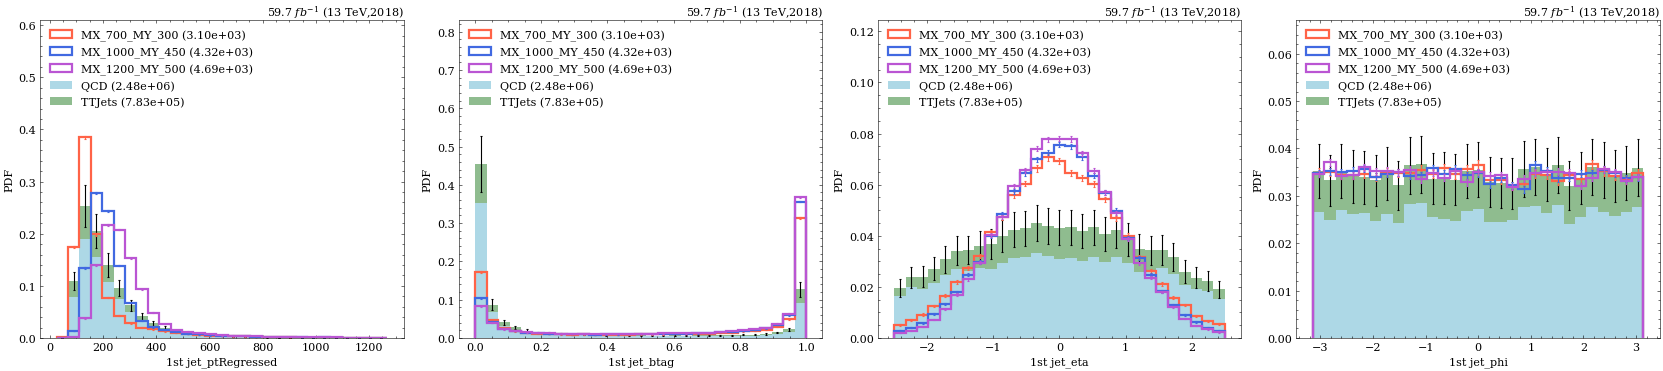

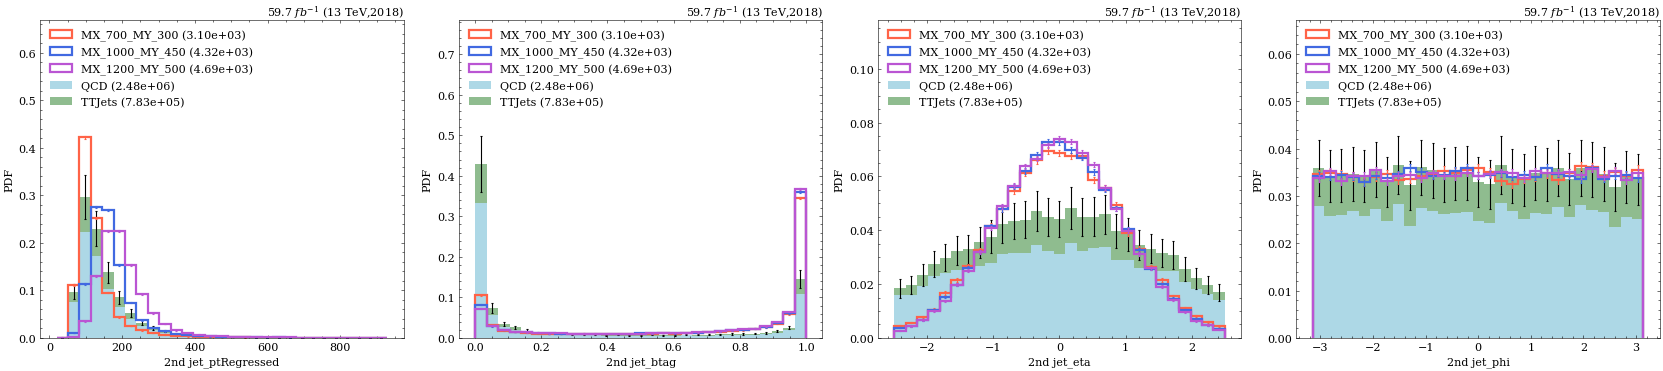

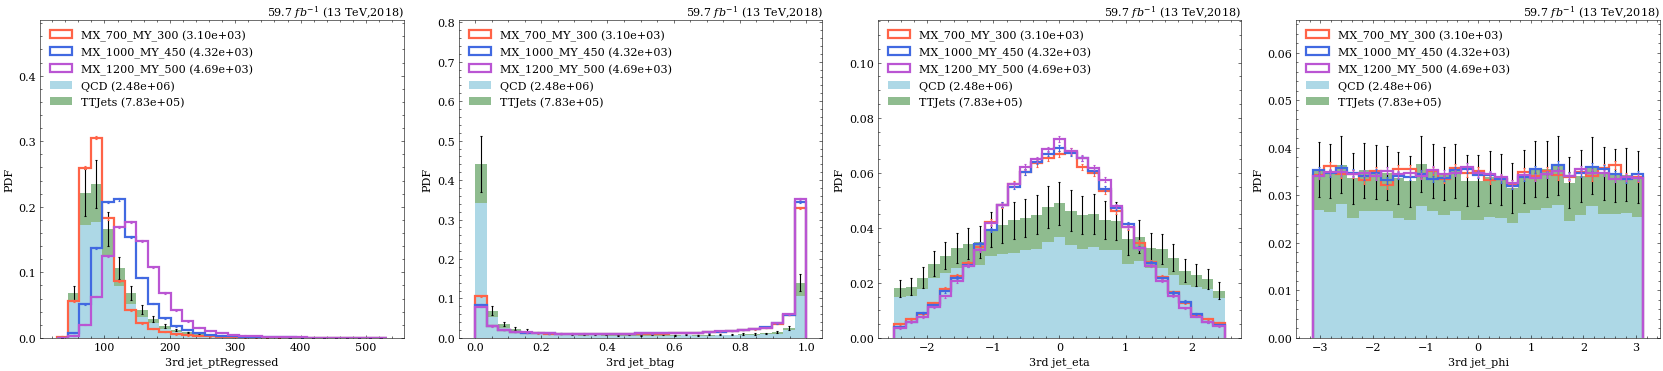

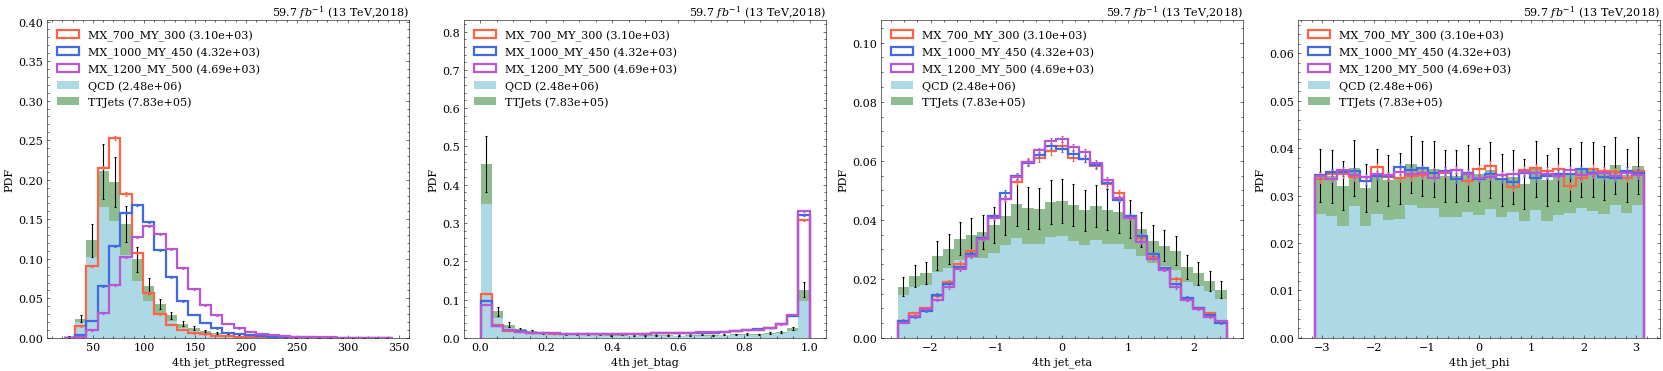

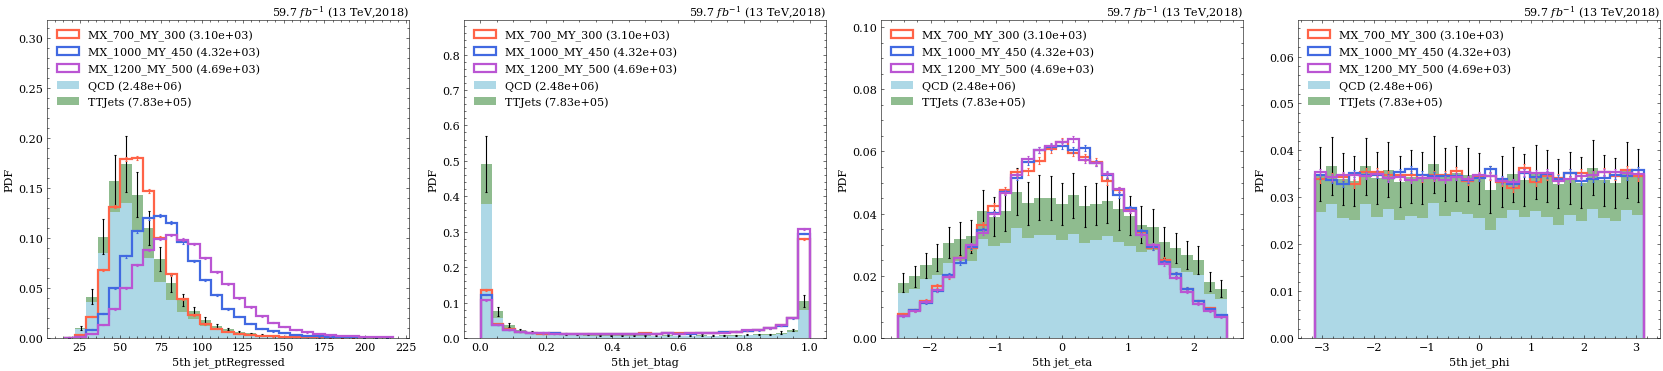

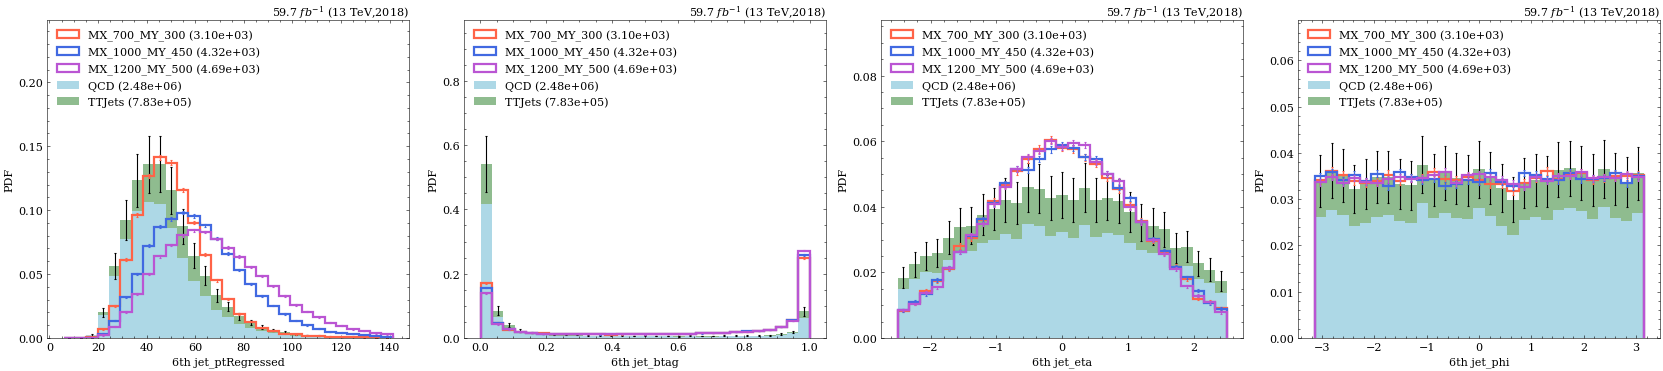

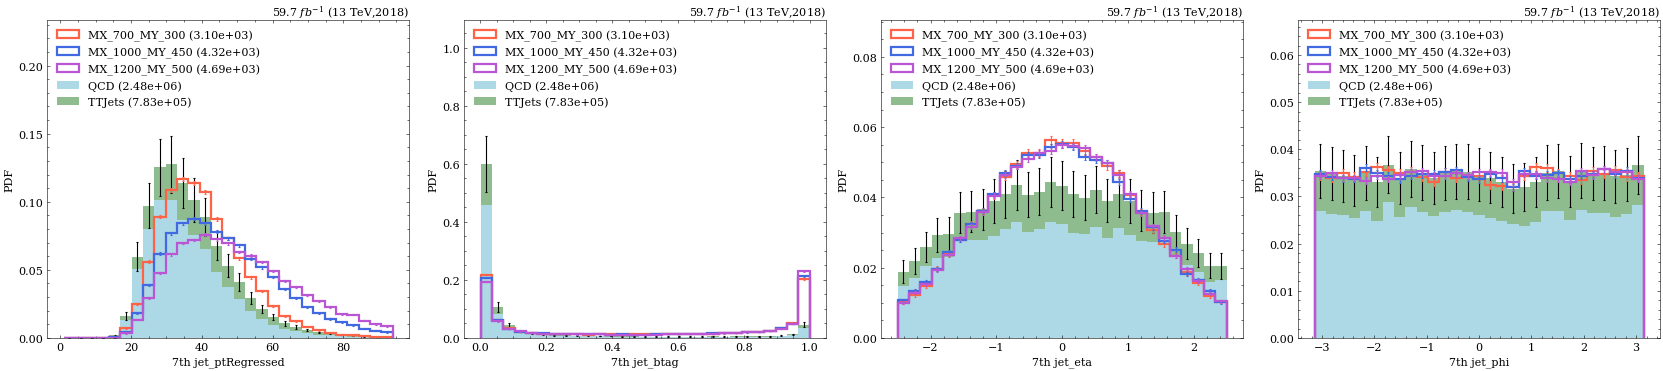

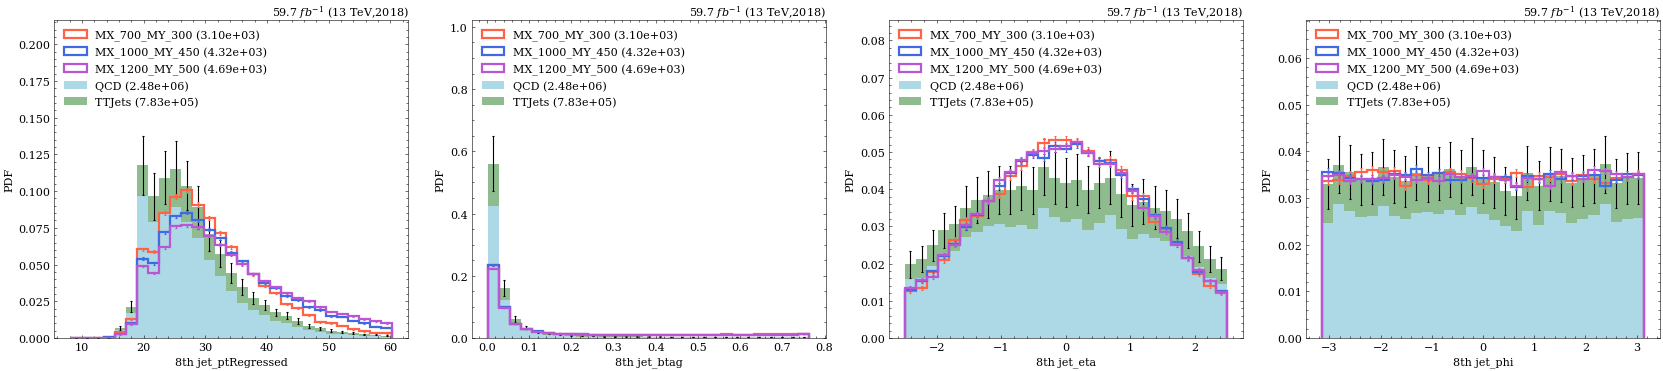

In [21]:
for i in range(8):
    study.quick( 
        signal+bkg, legend=True, 
        varlist=[f'jet_{var}[:,{i}]' for var in ('ptRegressed','btag','eta','phi')],
        efficiency=True,
        dim=-1,
        saveas=f'{dout}/{ordinal(i)}_pt_jet'
    )

In [22]:
varinfo.higgs_m = dict(bins=(0,500,30))
varinfo.higgs_dr = dict(bins=(0,4,30))

100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


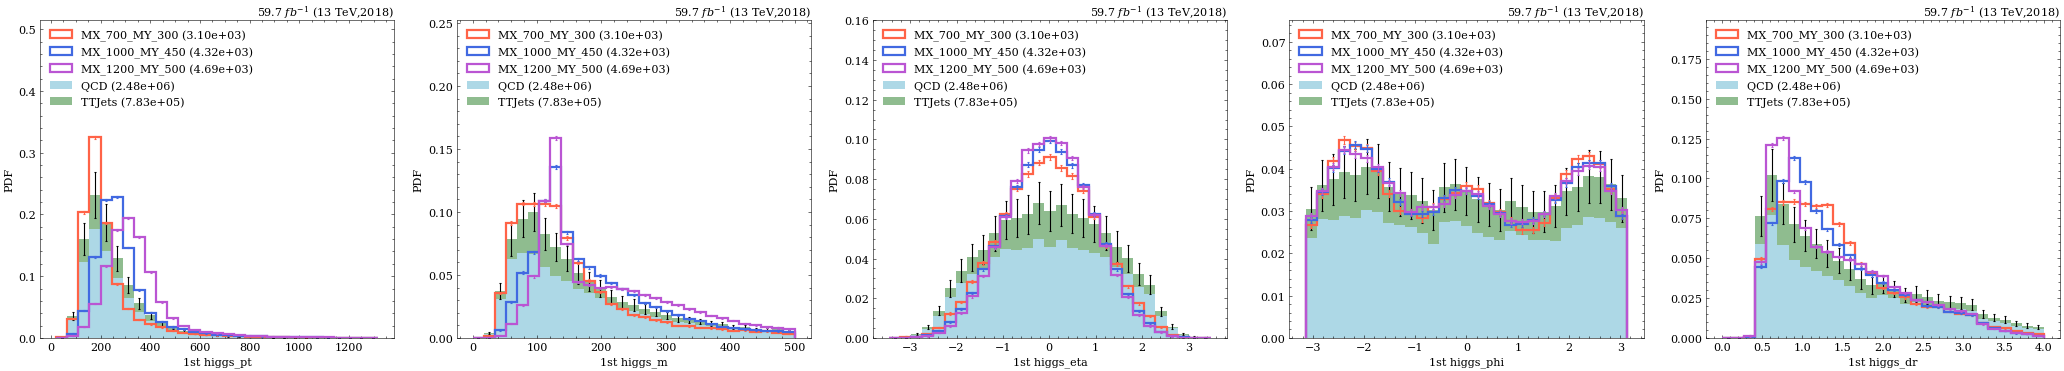

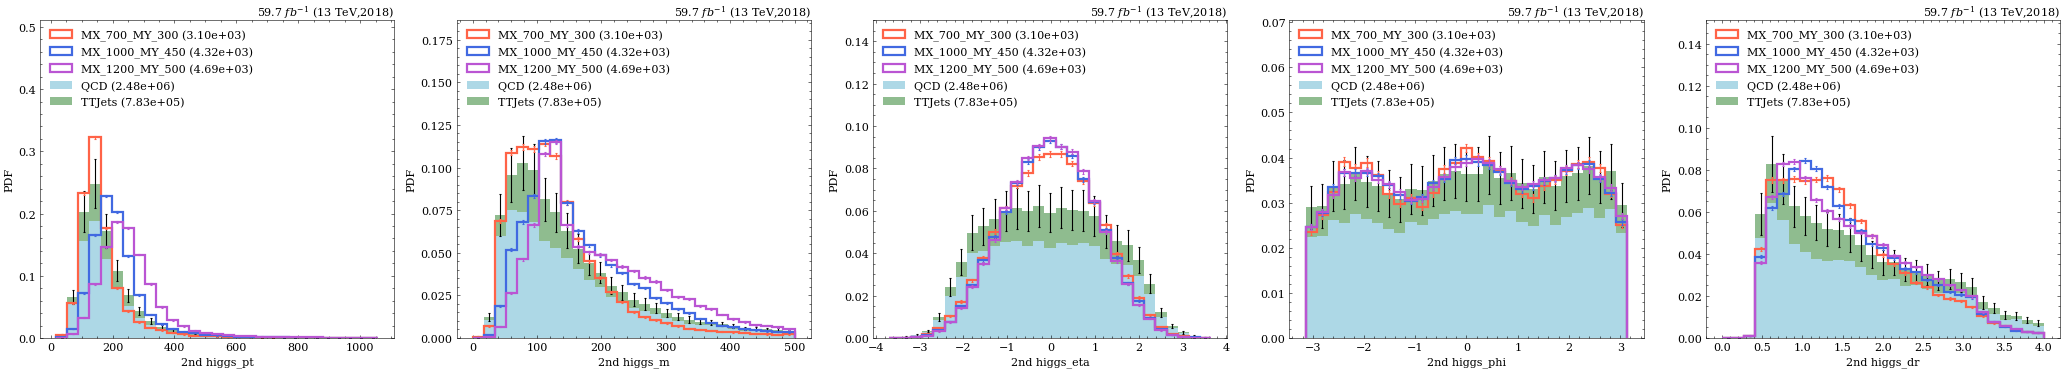

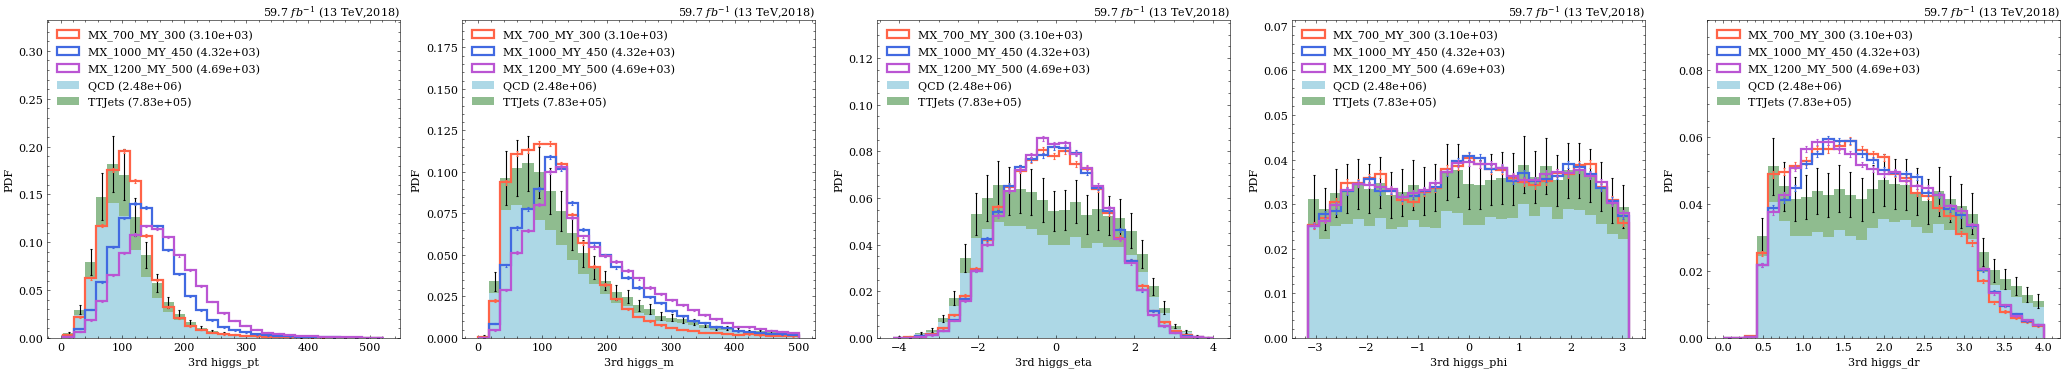

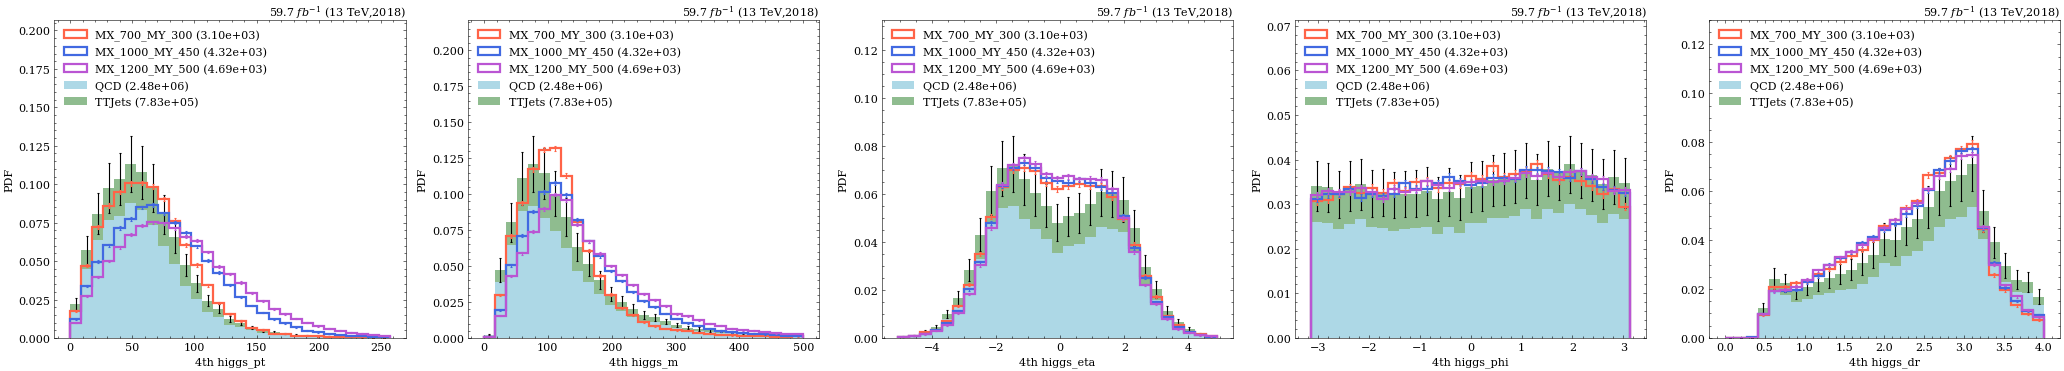

In [30]:
for i in range(4):
    study.quick( 
        signal+bkg, 
        # signal, 
        legend=True, efficiency=True,
        varlist=[f'higgs_{var}[:,{i}]' for var in ('pt','m','eta','phi','dr')],
        dim=-1,
        saveas=f'{ordinal(i)}_pt_higgs'
    )

In [23]:
# for i in range(2):
#     study.quick( 
#         signal+bkg, legend=True, efficiency=True,
#         varlist=[f'Y{i+1}_{var}' for var in ('pt','m','eta','phi')],
#         dim=-1,
#         saveas=f'{dout}/{ordinal(i)}_pt_y'
#     )

In [24]:
varinfo.X_m = dict(bins=(500,2000,30))

100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


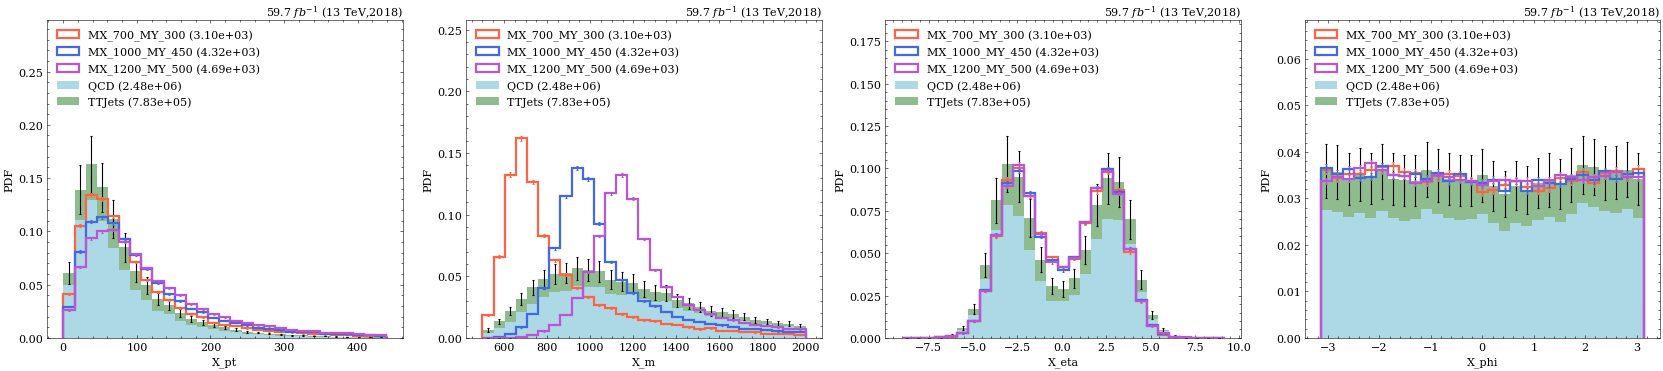

In [25]:
study.quick( 
    signal+bkg, legend=True, efficiency=True,
    varlist=[f'X_{var}' for var in ('pt','m','eta','phi')],
    dim=-1,
    saveas=f'{dout}/X'
)

100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


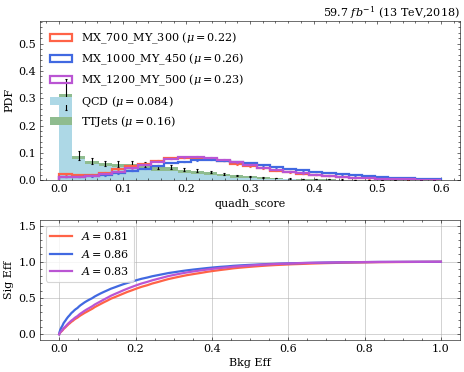

In [24]:
study.quick(
    signal+bkg, 
    legend=True,
    h_label_stat='mean',
    # log=True, 
    efficiency=True,
    varlist=['quadh_score'],
    binlist=[(0,0.6,30)],
    # xlabels=['Minimum Higgs Mass Asymmetry'],

    **study.auroc,
    saveas=f'{dout}/quadh_score_roc',
)

In [28]:
varinfo.X_m = dict(bins=(500,2000,30))

100%|██████████| 1/1 [00:42<00:00, 42.39s/it]


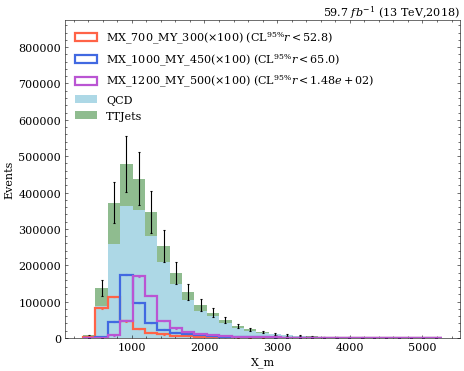

In [25]:
study.quick(
    signal+bkg, legend=True,
    # scale=[100]*len(signal),
    plot_scale=[100]*len(signal),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/no_cuts'
)

100%|██████████| 1/1 [00:11<00:00, 11.16s/it]


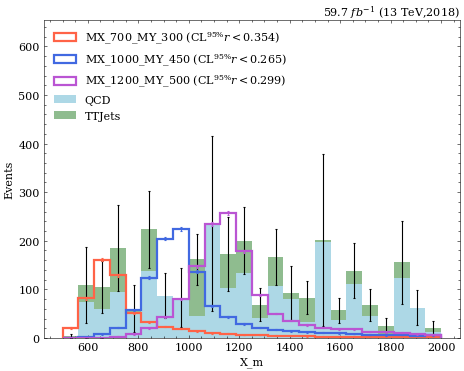

In [39]:
study.quick(
    signal+bkg, legend=True,
    masks=lambda t:t.n_loose_btag==8,
    varlist=['X_m'],
    binlist=[(500,2000,25)],
    limits=True,
    saveas=f'{dout}/limits/n_loose_btag==8'
)

In [26]:
loose_btag_mask = lambda t:t.n_loose_btag>=5

100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


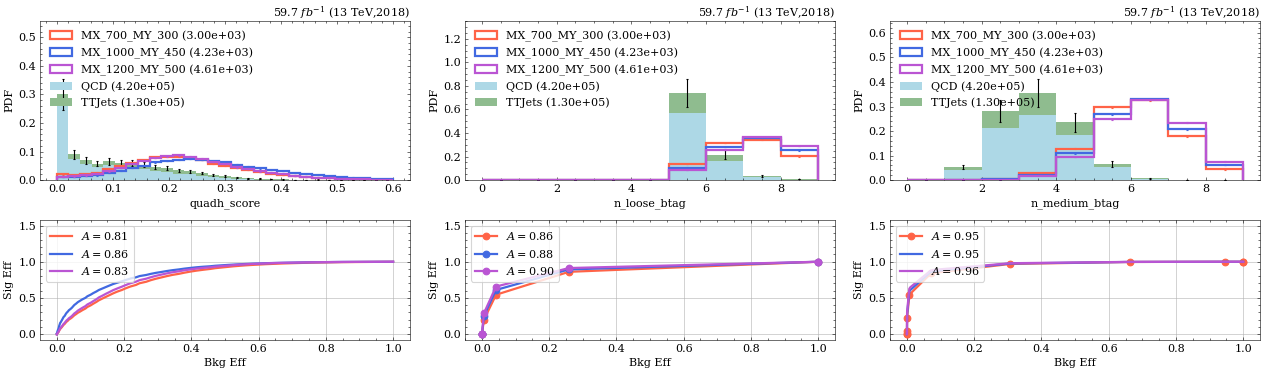

In [27]:
study.quick(
    signal+bkg, 
    masks=loose_btag_mask,
    legend=True,
    # h_label_stat='mean',
    # log=True, 
    efficiency=True,
    varlist=['quadh_score','n_loose_btag','n_medium_btag'],
    binlist=[(0,0.6,30)],
    dim=-1,
    # xlabels=['Minimum Higgs Mass Asymmetry'],
    **study.auroc,
)

100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


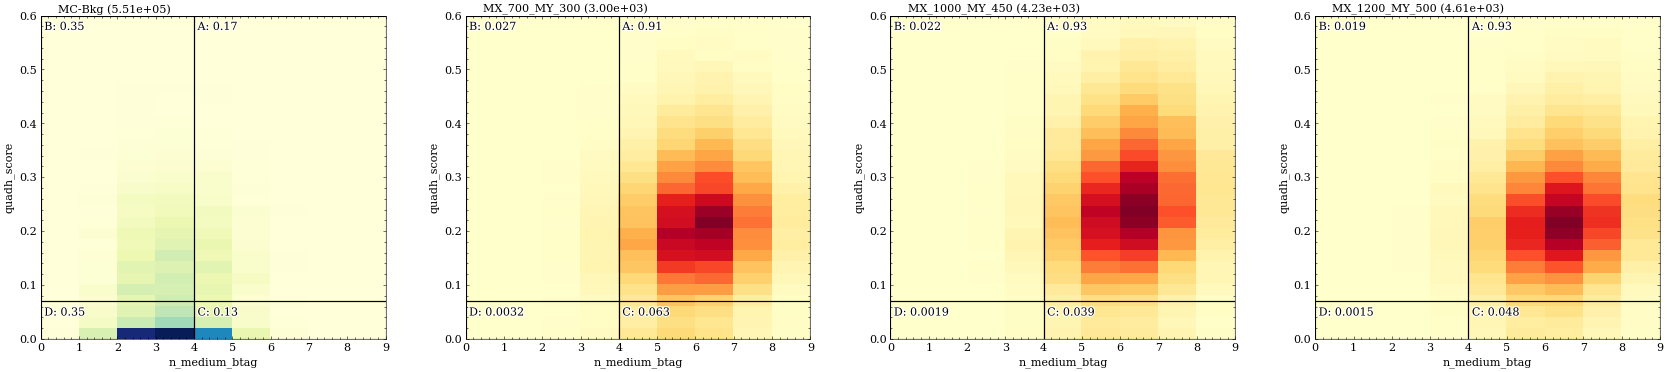

In [33]:
study.quick2d(
    signal+bkg, 
    masks=loose_btag_mask,
    # h_label_stat='mean',
    # log=True, 
    varlist=['n_medium_btag','quadh_score',],
    binlist=[None,(0,0.6,30)],
    exe=draw_abcd(x_r=(0,4,9), y_r=(0,0.07,0.6))
)

In [34]:
bdt = ABCD(
    features=['X_m','X_pt'],
    a = lambda t : loose_btag_mask(t) & (t.n_medium_btag >  4) & (t.quadh_score > 0.07),
    b = lambda t : loose_btag_mask(t) & (t.n_medium_btag <= 4) & (t.quadh_score > 0.07),
    c = lambda t : loose_btag_mask(t) & (t.n_medium_btag >  4) & (t.quadh_score < 0.07),
    d = lambda t : loose_btag_mask(t) & (t.n_medium_btag <= 4) & (t.quadh_score < 0.07),
)

100%|██████████| 1/1 [00:18<00:00, 18.60s/it]


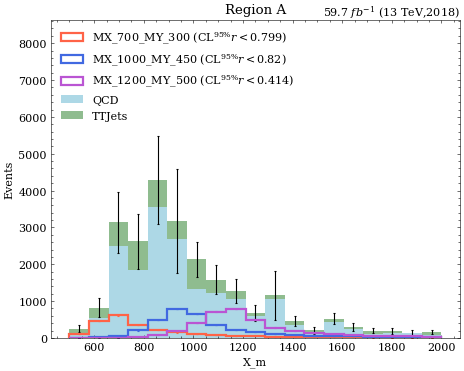

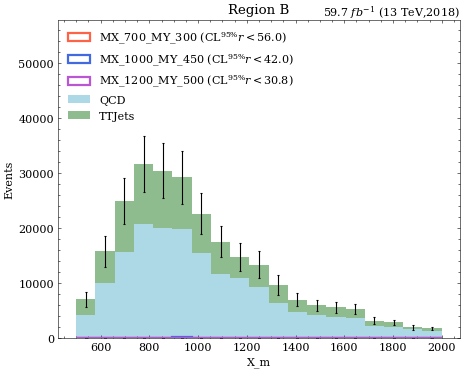

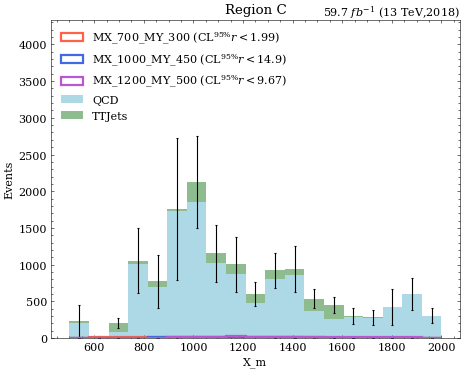

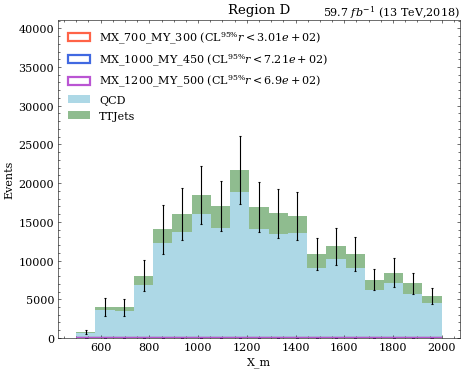

In [35]:
varinfo.X_m = dict(bins=(500,2000,20))
for r in ('a','b','c','d'):
    study.quick(
        signal + bkg, 
        legend=True,
        # plot_scale=[10]*len(signal),
        masks=getattr(bdt,r),
        varlist=['X_m'],
        limits=True,
        title=f'Region {r.upper()}',
        saveas=f'{dout}/limits/region_{r}'
    )

In [36]:
bdt.train(bkg)
bdt.print_results(bkg)

--- ABCD Results ---
k = 6.277e-02
k*(b/a)-1  = -31.95%
BDT(b)/a-1 = -24.84%



100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


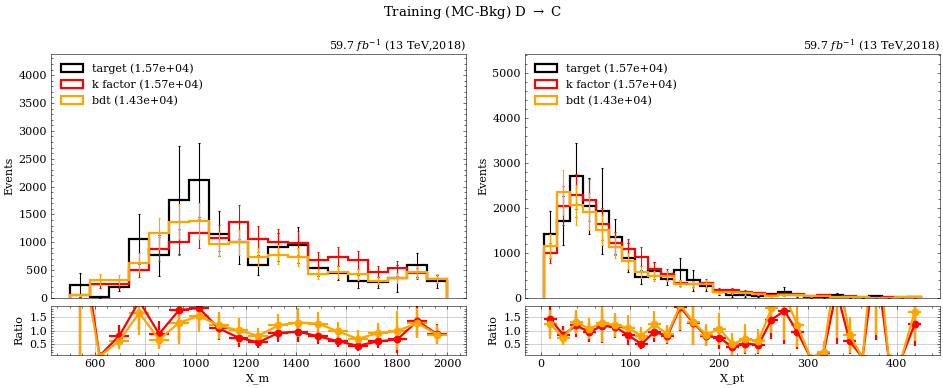

In [37]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','red','orange'], legend=True,
    masks=[bdt.c]*len(bkg)+[bdt.d]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,
    suptitle='Training (MC-Bkg) D $\\rightarrow$ C',
    ratio=True,
    saveas=f'{dout}/bdt/training'
)

100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


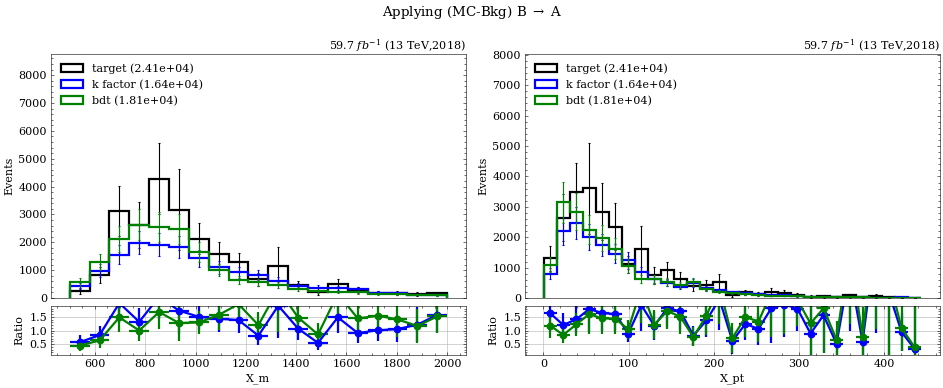

In [38]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','blue','green'], legend=True,
    masks=[bdt.a]*len(bkg)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,
    suptitle='Applying (MC-Bkg) B $\\rightarrow$ A',
    saveas=f'{dout}/bdt/applying',
    ratio=True,
)

100%|██████████| 1/1 [00:17<00:00, 17.15s/it]


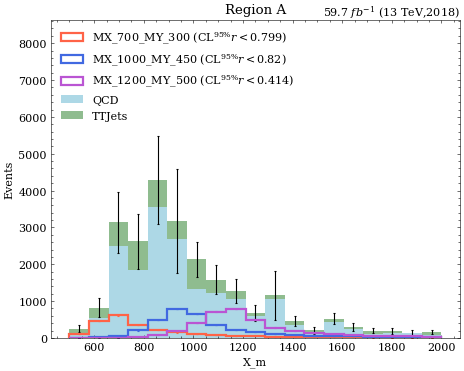

In [39]:
study.quick(
    signal + bkg, 
    legend=True,
    masks=bdt.a,
    varlist=['X_m'],
    limits=True,
    title='Region A',
    saveas=f'{dout}/limits/region_a'
)

100%|██████████| 1/1 [00:16<00:00, 16.38s/it]


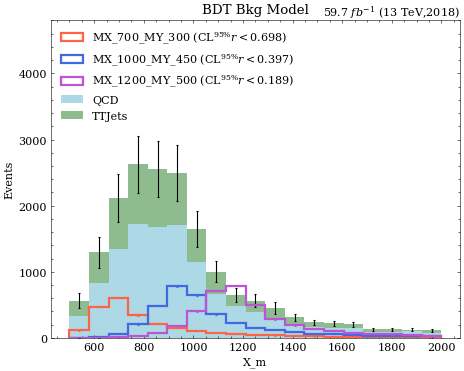

In [40]:
study.quick(
    signal + bkg, 
    legend=True,
    masks=[bdt.a]*len(signal)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(signal)+[bdt.reweight_tree]*len(bkg),
    varlist=['X_m'],
    title='BDT Bkg Model',
    limits=True,
    saveas=f'{dout}/limits/bdt_bkg_model'
)